In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import mapclassify

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'

In [3]:
pd.__version__

'2.1.1'

In [4]:
gpd.__version__

'0.14.4'

## Shapefile für den Zensus-Stichtag 15. Mai 2022
Freier Download, Verwendung mit Quellenangabe BKG  
https://www.zensus2022.de/DE/Presse/Grafik/shapefile.html

<Axes: >

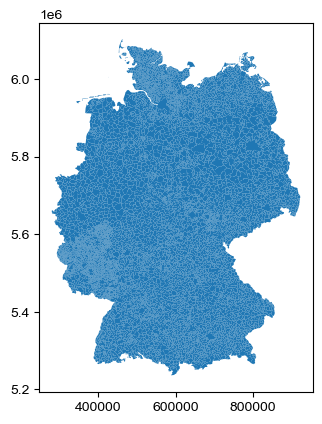

In [5]:
# erzeugt mit mapshaper.org : filter "GF==4"; filter-fields ARS; simplification 4%
gemeindegrenzen = gpd.read_file("VG250_GEM_simplified.zip").set_index("ARS")
gemeindegrenzen.plot()

<Axes: >

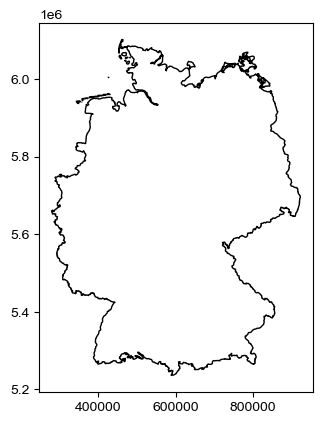

In [6]:
# erzeugt mit mapshaper.org : dissolve
bundesgrenze = gpd.read_file("VG250_DE_simplified.zip")
bundesgrenze.plot(facecolor="None")

<Axes: >

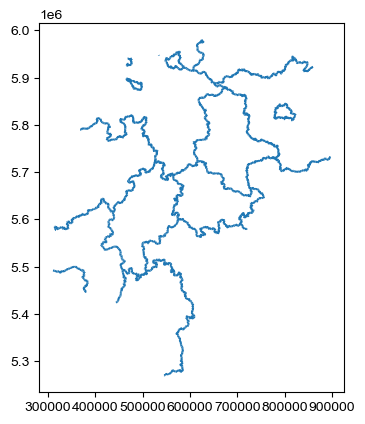

In [7]:
# erzeugt mit mapshaper.org : innerlines where='A.ARS.substring(0,2) != B.ARS.substring(0,2)'
laendergrenzen = gpd.read_file("VG250_LAN_mesh_simplified.zip")
laendergrenzen.plot()

## Ergebnisse des Zensus 2022 ab 25. Juni 2024
Vorabveröffentlichung der leeren Tabellenrahmen seit 19. Juni 2024 unter  
https://www.zensus2022.de/DE/Ergebnisse/_inhalt.html#toc-2  
Die dort angebotene ZIP-Datei (9.1 MB) enthält mehrere Excel-Dateien, die jeweils ein oder mehrere thematisch gegliederte CSV-Sheets enthalten und die direkt verarbeitet werden können. Die Excel Dateien müssen nicht bearbeitet werden. Getesteter Beispielcode, anschließend einige Hinweise:

## Zeichenerklärung
Aus dem Sheet "Erläuterungen zur Methodik"  

Beispiel **Gebäude- und Wohnungen**  (Vollerhebung)

```
–     = Genau Null oder auf Null geändert
( )   = Aussagewert eingeschränkt, da der Zahlenwert statistisch relativ unsicher ist
.     = Zahlenwert unbekannt oder geheim
```

Beispiel **Bildung und Erwerbstätigkeit** (aus der Stichprobenerhebung hochgerechnete Ergebnisse)  
```
–     = Genau Null oder auf Null geändert
/      = Keine Angabe, da Zahlenwert nicht sicher genug
.      = Zahlenwert unbekannt oder geheim
```

## Hinweise zum Einlesen der Daten (Szenario 1, Daten-csv)
* Die CSV-Sheets können direkt aus der Excel-Datei eingelesen werden, in nachstehendem Beispiel `CSV-Wohnungen`
* Einige Programmversionen von `openpyxl` (Excel-Engine von Pandas) haben in der Vergangenheit Probleme gemacht,  
ggf. Fehlermeldung in Suchmaschine eingeben und Version up- oder downgraden
* Der Regionalschlüssel `_RS` enthält führende Nullen und muss als Zeichenkette (String) eingelesen werden
* Die Datenspalten können neben Ziffern auch Zeichen enthalten, z.B. den längeren Gedankenstrich `–` für _Genau Null oder auf Null geändert_ (dies entspricht dem kürzeren Minuszeichen `-` in Genesis-Systemen), weitere Zeichen entsprechend dem Tabellenblatt Methodenbeschreibung
* Für Statistikzwecke z.B. als `NaN` codieren, hier mit `na_values=` um die Erkennung als Zahl zu erhalten
* Es können deutsche Dezimalkommata vorkommen, daher die Angabe `decimal=","` um die Erkennung als Zahl zu erhalten

In [8]:
# Tabelle mit Zufallszahlen im Wertebereich 0-50 und einer Nachkomamstelle befüllt
# Gemeinde Wiesbaden mit 'nichts vorhanden' befüllt (Gedankenstrich)

regioTabelle_GWZ = pd.read_excel("Regionaltabelle_Gebäude_Wohnungen_Zufall.xlsx", 
                                 sheet_name="CSV-Wohnungen",
                                 dtype={"_RS":str}, decimal=",",
                                 na_values=["–","-",".","/","X"])\
                                .set_index("_RS")

## Hinweise zum Einlesen der Daten (Szenario 2, geklammerte Werte)
* Die CSV-Sheets können direkt aus der Excel-Datei eingelesen werden, in nachstehendem Beispiel `CSV-Wohnungen`
* Alles wird zunächst als Zeichenkette (String) eingelesen
* Der Regionalschlüssel `_RS` wird als Index gesetzt
* Die Datenspalten (alle rechts von "Regionalebene) werden mit `.to_numeric(errors="coerce")`  
zu Zahlen konvertiert, einschließlich `NaN` wenn das scheitert
* Durch das Einlesen im Excel-Format werden die landesspezifischen Dezimalzeichen bereits erkannt

In [9]:
# Tabelle mit Zufallszahlen im Wertebereich 0-50 und einer Nachkomamstelle befüllt
# Gemeinde Wiesbaden zu Testzwecken mit 'Genau Null oder auf Null geändert' befüllt (Gedankenstrich)
# Gemeinden Kiel und Dobitschen haben zu Testzwecken die geklammerte Werte (23,23) und (42,42)

regioTabelle_GWZ = pd.read_excel("Regionaltabelle_Gebäude_Wohnungen_Zufall.xlsx", 
                                 sheet_name="CSV-Wohnungen",
                                 dtype=str)\
                                .set_index("_RS")

In [10]:
regioTabelle_GWZ.head(7)["meinZufall"]

_RS
00                 40.2
01                 37.1
01001                39
010010000000       10.1
01002              11.8
010020000000    (23,23)
01003              18.8
Name: meinZufall, dtype: object

In [11]:
regioTabelle_GWZ["meinZufall"].describe()

count     12439
unique      504
top        26.8
freq         39
Name: meinZufall, dtype: object

### ab Spalte 4 in Zahlen konvertieren, NaN wenn es nicht klappt

In [12]:
for col in regioTabelle_GWZ.columns[3:]:

   regioTabelle_GWZ[col] = pd.to_numeric(regioTabelle_GWZ[col], errors="coerce")    

In [13]:
regioTabelle_GWZ.head(7)

,Berichtszeitpunkt,Name,Regionalebene,GEBAEUDEART_SYS_1,GEBAEUDEART_SYS_11,GEBAEUDEART_SYS_111,GEBAEUDEART_SYS_112,GEBAEUDEART_SYS_12,ZAHLWOHNGN_HHG__1,ZAHLWOHNGN_HHG__2,...,LEERSTAND_DAUER__2,LEERSTAND_DAUER__3,LEERSTAND_DAUER__4,LEERSTAND_GRUND__1,LEERSTAND_GRUND__2,LEERSTAND_GRUND__3,LEERSTAND_GRUND__4,LEERSTAND_GRUND__5,LEERSTAND_GRUND__6,meinZufall
_RS,,,,,,,,,,,,,,,,,,,,,
00,20220515,Deutschland,Bund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.2
01,20220515,Schleswig-Holstein,Land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.1
01001,20220515,"Flensburg, Stadt",Stadtkreis/kreisfreie Stadt/Landkreis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
010010000000,20220515,"Flensburg, Stadt",Gemeinde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1
01002,20220515,"Kiel, Landeshauptstadt",Stadtkreis/kreisfreie Stadt/Landkreis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.8
010020000000,20220515,"Kiel, Landeshauptstadt",Gemeinde,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01003,20220515,"Lübeck, Hansestadt",Stadtkreis/kreisfreie Stadt/Landkreis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.8


In [14]:
regioTabelle_GWZ["meinZufall"].describe()

count    12435.000000
mean        24.703563
std         14.445175
min          0.000000
25%         12.200000
50%         24.500000
75%         37.200000
max         50.000000
Name: meinZufall, dtype: float64

In [15]:
regioTabelle_GWZ.columns

Index(['Berichtszeitpunkt', 'Name', 'Regionalebene', 'GEBAEUDEART_SYS_1',
       'GEBAEUDEART_SYS_11', 'GEBAEUDEART_SYS_111', 'GEBAEUDEART_SYS_112',
       'GEBAEUDEART_SYS_12', 'ZAHLWOHNGN_HHG__1', 'ZAHLWOHNGN_HHG__2',
       'ZAHLWOHNGN_HHG__3', 'ZAHLWOHNGN_HHG__4', 'ZAHLWOHNGN_HHG__5',
       'BAUJAHR_10JA__01', 'BAUJAHR_10JA__02', 'BAUJAHR_10JA__03',
       'BAUJAHR_10JA__04', 'BAUJAHR_10JA__05', 'BAUJAHR_10JA__06',
       'BAUJAHR_10JA__07', 'BAUJAHR_10JA__08', 'BAUJAHR_10JA__09',
       'BAUJAHR_10JA__10', 'EIGENTUM__1', 'EIGENTUM__2', 'EIGENTUM__3',
       'EIGENTUM__4', 'EIGENTUM__5', 'EIGENTUM__6', 'EIGENTUM__7',
       'EIGENTUM__8', 'HEIZTYP__1', 'HEIZTYP__2', 'HEIZTYP__3', 'HEIZTYP__4',
       'HEIZTYP__5', 'HEIZTYP__6', 'ENERGIETRAEGER__1', 'ENERGIETRAEGER__2',
       'ENERGIETRAEGER__3', 'ENERGIETRAEGER__4', 'ENERGIETRAEGER__5',
       'ENERGIETRAEGER__6', 'ENERGIETRAEGER__7', 'NERGIETRAEGER__8',
       'ENERGIETRAEGER__9', 'NUTZUNG__01', 'NUTZUNG__02', 'NUTZUNG__03',
   

In [16]:
# ausgewählte Datenspalten, die direkt kartiert werden können
regioTabelle_GWZ[regioTabelle_GWZ["Regionalebene"]=="Gemeinde"]\
            [["Name","QMMIETE","LEQ","ETQ","FLAECHE","meinZufall"]]

,Name,QMMIETE,LEQ,ETQ,FLAECHE,meinZufall
_RS,,,,,,
010010000000,"Flensburg, Stadt",NaN,NaN,NaN,NaN,10.1
010020000000,"Kiel, Landeshauptstadt",NaN,NaN,NaN,NaN,NaN
010030000000,"Lübeck, Hansestadt",NaN,NaN,NaN,NaN,30.6
010040000000,"Neumünster, Stadt",NaN,NaN,NaN,NaN,9.6
010510011011,"Brunsbüttel, Stadt",NaN,NaN,NaN,NaN,40.3
...,...,...,...,...,...,...
160775051011,Göpfersdorf,NaN,NaN,NaN,NaN,43.6
160775051023,Langenleuba-Niederhain,NaN,NaN,NaN,NaN,26.8
160775051036,Nobitz,NaN,NaN,NaN,NaN,3.4


## Daten mit GeoDataFrame aus Shapefile verbinden
Es wird entlang der jeweiligen Indices (Regionalschlüssel) zusammengeführt.  
Die Regionaltabellen als auch das bereitgestellt Shapefile enthalten ebenfalls die Ebenen Gemeindeverbände und Kreise, das Vorgehen wie hier beschreiben würde für diese immer identisch ablaufen.

In [17]:
regioTabelle_GWZ_gem = gemeindegrenzen.join(regioTabelle_GWZ)

In [18]:
regioTabelle_GWZ_gem.head(3)[["Name","geometry","QMMIETE","LEQ","ETQ","FLAECHE","meinZufall"]]

,Name,geometry,QMMIETE,LEQ,ETQ,FLAECHE,meinZufall
ARS,,,,,,,
010010000000,"Flensburg, Stadt","POLYGON ((527173.204 6075202.115, 527914.416 6...",NaN,NaN,NaN,NaN,10.1
010020000000,"Kiel, Landeshauptstadt","POLYGON ((576003.314 6031749.596, 577425.188 6...",NaN,NaN,NaN,NaN,NaN
010030000000,"Lübeck, Hansestadt","POLYGON ((624906.198 5980395.728, 625243.141 5...",NaN,NaN,NaN,NaN,30.6


## Karte zeichnen/ausgeben
Zur massenhaften schnellen Exploration empfiehlt sich die Klasseneinteilung mit `NaturalBreaks` (Jenks).  
Wählt man später mit `userdefined` Klassengrenzen, kann man auch das Zahlenformat `fmt` der Legende anpassen, z.B. `{:.0f}` für ganze Zahlen.  
Als Farbschemata können u.a. [Colorbrewer](https://colorbrewer2.org/#type=sequential&scheme=PuBuGn&n=6)-Kürzel wie `PuGn` oder `viridis` verwendet werden.

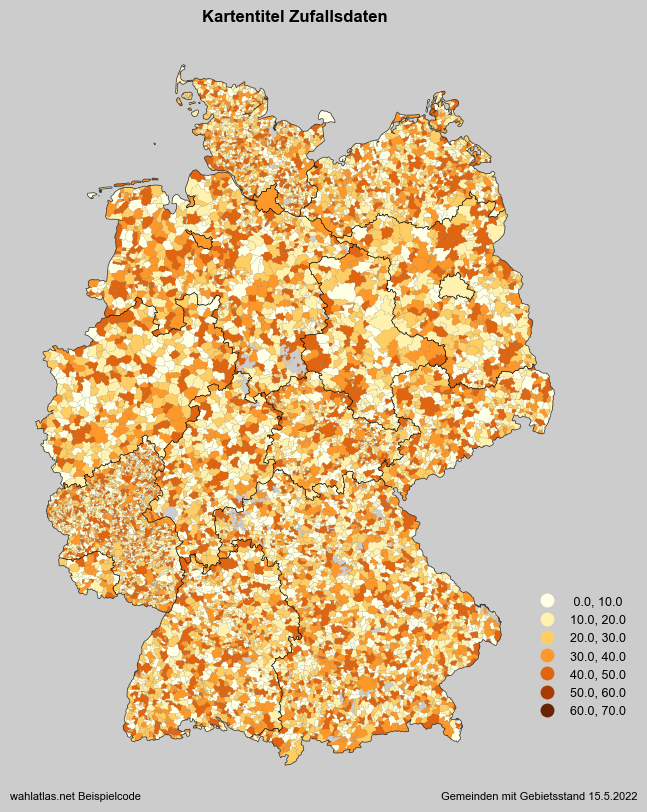

In [19]:
fig, ax = plt.subplots(1, figsize=(12,10))
fig.set_facecolor("#ccc")
ax.axis("off")

ax.set_title("Kartentitel Zufallsdaten", fontdict={"fontsize":12, "fontweight": "bold"})
ax.annotate("wahlatlas.net Beispielcode", xy=(0,0), xycoords="axes fraction", ha="left", fontsize=8)
ax.annotate("Gemeinden mit Gebietsstand 15.5.2022", xy=(1.1,0), xycoords="axes fraction", ha="right", fontsize=8)
bundesgrenze.plot(facecolor = "None", linewidth = 1, edgecolor = "#333", ax=ax )

regioTabelle_GWZ_gem.plot(column = "meinZufall", cmap = "YlOrBr",
                          #scheme = "NaturalBreaks", k=7,
                          scheme = "userdefined", classification_kwds = {"bins": [10,20,30,40,50,60,70]},
                          legend = True, legend_kwds = {"fmt": "{:.1f}", "frameon": False,
                                                       "markerscale": 1, "fontsize": 9,
                                                       "bbox_to_anchor": (1.1, 0.28)},
                          linewidth = .05, edgecolor = "#333", ax=ax )

laendergrenzen.plot(facecolor = "None", linewidth = .5, edgecolor = "#000", ax=ax )
plt.savefig("meine_Karte_Zensus2022.png", bbox_inches="tight", pad_inches=.15, dpi=96) #  .svg | .pdf | .png
plt.show()